In [ ]:
from google.colab import drive

ROOT = '/content/drive'     # default for the drive
drive.mount(ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dtaidistance
!pip install scikeras
!pip install sktime

In [ ]:
!pip freeze |sed s/==.*//> pip_freeze_colab_tsc_no_versions_gpu.txt
!pwd
!diff pip_freeze_colab_tsc_no_versions*

/content
diff: missing operand after 'pip_freeze_colab_tsc_no_versions_gpu.txt'
diff: Try 'diff --help' for more information.


In [ ]:
!mv pip_freeze_colab_tsc.txt /content/drive

mv: cannot stat 'pip_freeze_colab_tsc.txt': No such file or directory


In [ ]:
from keras import models
from keras import layers
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import linregress
from sktime.datatypes._panel._convert import (
    from_multi_index_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_multi_index,
    from_nested_to_3d_numpy,
)
#from sktime.utils.data_io import make_multi_index_dataframe
from sktime.datasets import make_multi_index_dataframe
import sys

sys.path.insert(1, "/content/drive/My Drive/Git/InceptionTime")
from classifiers import inception


In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
import sktime
sktime.__version__

'0.10.0'

In [ ]:

# initial filtering based on experimental setup
def initial_filtering(data):
    data = data[~data["comment"].isin(["stress_control"])]
    data = data[~data["comment"].isin(["H2B"])]
    data = data[data["guide"].str.contains('1398') | data["guide"].str.contains('1514')]
    data = data[data["time"] < 40]

    return data

#data = initial_filtering(data)

#data.head()
#data.info()

In [ ]:
def normalize_xy(data):
    # add x and y max per time series
    data = data.join(data.groupby(['file','particle'])['x'].max(), on=['file','particle'], rsuffix='_max')
    data = data.join(data.groupby(['file','particle'])['y'].max(), on=['file','particle'], rsuffix='_max')
    data = data.join(data.groupby(['file','particle'])['x'].min(), on=['file','particle'], rsuffix='_min')
    data = data.join(data.groupby(['file','particle'])['y'].min(), on=['file','particle'], rsuffix='_min')

    # normalize x and y
    data['x_norm'] = data['x'] - data['x_min']
    data['y_norm'] = data['y'] - data['y_min']

    return data

#data = normalize_xy(data)

def create_instance_index(data):
    # combine file and particle columns for using as instance index later on
    data['fp'] = data['file'] + '__' + data['particle'].astype(str)
    return data

#data = create_instance_index(data)
#data.head()


In [ ]:

def select_columns(data, cols):
    data = data[cols]
    return data

#datam = data_to_multi_index(data)
#datam.head()


In [ ]:
def nested_max(row, col_name='col'):
    return row[col_name].max()

def nested_size(row, col_name='col'):
    return row[col_name].size

def format_class_col(datan):
    datan['class'] = datan.apply(nested_max, axis=1, col_name='serum_conc_percent')
    datan['class'] = (datan['class'] / 10).astype('int')

    datan = datan.drop(columns=['serum_conc_percent'])
    return datan

def add_nframes_col_nested(datan, col):
    datan['nframes_nested'] = datan.apply(nested_size, axis=1, col_name=col)
    return datan

def add_nframes_col(data):
    #datan['nframes'] = datan.apply(nested_size, axis=1, col_name=col)
    data = data.copy()
    #data['nframes'] = data.groupby('fp')['frame'].transform('max') + 1
    data['nframes'] = data.groupby('fp')['frame'].transform('count')
    
    return data

#datan = from_multi_index_to_nested(datam, instance_index='fp')
#datan = add_nframes_col(datan)
#datan = format_class_col(datan)


In [ ]:
#tmp = create_instance_index(data)
#tmp = add_nframes_col(tmp)
#tmp.groupby(by=['fp'])['frame','nframes'].min()
#tmp['nframes'].unique()

In [ ]:
#datan['class'].unique()
#datan.head(2)
#datan.groupby('nframes').count()

In [ ]:
def fix_unequal_frame_counts(datan, n):
    # drop all series where frame count is not n
    datan = datan[datan['nframes']==n]
    return datan
    
#datan = fix_unequal_frame_counts(datan)
#datan.groupby('nframes').count()

def separate_observations_and_classes(datan):
    # separate class vector...
    y = datan['class'].values
    datan = datan.drop(columns=['class'])
    #print(datan.head())

    # ... and observations
    X = from_nested_to_3d_numpy(datan)
    return X,y

#X,y = separate_observations_and_classes(datan)


In [ ]:
#print(X.shape)
#print(y.shape)
#print(Y.shape)
#print(Y[:15,:])

In [ ]:
def displacement(row):
    return math.sqrt(row['dx']**2 + row['dy']**2)

def angle(row):
    return math.atan(row['dy'] / row['dx'])

def add_features(df):
    df = df.copy()

    # displacement
    df['dx'] = df['x'].diff()
    df['dy'] = df['y'].diff()
    df['dxy'] = df.apply(displacement, axis=1)
    df = df[df['frame']!=0]
    #df = df.reset_index()

    # direction
    df['angle'] = df.apply(angle, axis=1)
    df['dangle'] = df['angle'].diff()

    # changes in area and perimeter
    df['dperimeter'] = df['perimeter_au'].diff()
    df['darea'] = df['area_micron'].diff()
    df = df[df['frame']!=1]
  
    return df
    

In [ ]:
# feature sets
# file is included in the first set because it is needed to create groups later on
fsets = {}
fsets['f_mot'] = ['x','y','min_dist_pxs','serum_conc_percent','file']
fsets['f_mot_morph'] = fsets['f_mot'] + ['area_micron','perimeter_au']
fsets['f_mot_morph_dyn'] = fsets['f_mot'] + ['dxy','angle','dangle','darea','dperimeter']

print(fsets['f_mot_morph_dyn'])

['x', 'y', 'min_dist_pxs', 'serum_conc_percent', 'file', 'dxy', 'angle', 'dangle', 'darea', 'dperimeter']


In [ ]:
def prepare_Xy(data, f_set_name):
    data = data.copy()
    data = initial_filtering(data)
    #data = normalize_xy(data)
    data = create_instance_index(data)
    data = add_nframes_col(data)
    debug0 = data.copy()
    #print(data.nframes.unique())
    #print(data.groupby(by=['nframes']).count())
    # keep rows that have the maximum number of frames
    idxmax = data.groupby(by=['nframes']).count()['file'].idxmax()
    data = fix_unequal_frame_counts(data, idxmax)
    #print(data.nframes.unique())

    datam = data.set_index(['fp','frame'])
    datam.replace(to_replace=pd.NA, value=None, inplace=True)

    cols = fsets[f_set_name]
    datam = datam[cols]
    debug1 = datam.copy()

    datan = from_multi_index_to_nested(datam, instance_index='fp')
    datan.to_csv("/content/drive/My Drive/Git/n_track_ML/scripts/datan.csv", index=False)
    debug2 = datan.copy()
    
    #print(datan['file'])
    # read group name from the last element of the series
    # index of first element might be 0,1 or 2, depending on how many elements
    # have been dropped because of adding features with df.diff()
    groups = datan['file'].apply(lambda x: x.iloc[-1])
    datan = datan.drop(columns=['file'])
    
    datan = format_class_col(datan)
    dfX = datan.drop(columns=['class'])

    #datan = add_nframes_col_nested(datan, 'x_norm')
    debug_data = datan.copy()
    #return debug_data
    X,y = separate_observations_and_classes(datan)
    return X, dfX, y, groups, debug1, debug2

#tmp = pipeline_xy(data)


In [ ]:
''' 
read the data 
'''

directory = Path("/content/drive/My Drive/Git/n_track_ML/scripts/")
data_file = directory / '63455ea_data_chromatin_live.csv'

data = pd.read_csv(data_file)
data = add_features(data)

X, dfX, y, groups, debugm, debugn = prepare_Xy(data, 'f_mot')

#test_data_file = directory / 'a286935_data_chromatin_live.csv'
#test_data = pd.read_csv(test_data_file)
#test_X, test_y, groups, debug_polar, debug_data = pipeline_xy(test_data, exclude_border=exclude_border)
print(X.shape)
print(y.shape)
print(groups.shape)

(289, 3, 28)
(289,)
(289,)


In [ ]:
debugm.isnull().values.any()
data.head()
debugn['file'][0]
groups

0      20200212marianasCh2_lamina_draq.sld_-_Capture_10
1      20200212marianasCh2_lamina_draq.sld_-_Capture_10
2      20200212marianasCh2_lamina_draq.sld_-_Capture_13
3      20200212marianasCh2_lamina_draq.sld_-_Capture_13
4      20200212marianasCh2_lamina_draq.sld_-_Capture_19
                             ...                       
284                  090621_guide_1398.sld_-_1398_7_t26
285                  090621_guide_1398.sld_-_1398_8_t29
286                  090621_guide_1398.sld_-_1398_8_t29
287                  090621_guide_1398.sld_-_1398_9_t33
288                  090621_guide_1398.sld_-_1398_9_t33
Name: file, Length: 289, dtype: object

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold

import warnings
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)

scoring=['accuracy', 'precision','recall','f1']
def print_score_mean_and_std(scores):
    for k in scores.keys():
        if "test" in k:
            print(k + ' mean: ' + str(np.mean(scores[k])))
            print(k + ' std: ' + str(np.std(scores[k])))

def format_scores_df(scores):
    scores = scores.drop(columns=['fit_time','score_time'])
    scores.columns = scores.columns.str.replace('test_','')
    #print(scores.mean())
    #print(scores.std())
    return scores

def cv_gkf(classifier, X, y, groups, splits):
    cv = GroupKFold(n_splits=splits)
    scores = cross_validate(classifier, X, y, cv=cv, scoring=scoring, groups=groups)
    print(classifier)
    print(cv)
    print_score_mean_and_std(scores)
    print()
    return scores

def cv_gkf_single_score(classifier, X, y, groups, splits):
    cv = GroupKFold(n_splits=splits)
    scores = cross_val_score(classifier, X, y, cv=cv, groups=groups)
    print(classifier)
    print(cv)
    print('accuracy mean: ' + str(scores.mean()))
    print('accuracy std: ' + str(scores.std()))
    #print_score_mean_and_std(scores)
    print()
    return scores

def cv_gss(classifier, X, y, groups):
    cv = GroupShuffleSplit(n_splits=20, test_size=0.25, random_state=0)
    scores = cross_validate(classifier, X, y, cv=cv, scoring=scoring, groups=groups)
    print(classifier)
    print(cv)
    print_score_mean_and_std(scores)
    print()
    return scores

def cv_gss_single_score(classifier, X, y, groups):
    cv = GroupShuffleSplit(n_splits=20, test_size=0.25, random_state=0)
    scores = cross_val_score(classifier, X, y, cv=cv, groups=groups)
    print(classifier)
    print(cv)
    print('accuracy mean: ' + str(scores.mean()))
    print('accuracy std: ' + str(scores.std()))
    print()
    return scores

def cv_logo(classifier, X, y, groups):
    cv = LeaveOneGroupOut()
    scores = cross_validate(classifier, X, y, cv=cv, scoring=scoring, groups=groups)
    print(classifier)
    print(cv)
    print_score_mean_and_std(scores)
    print()
    return scores


def cv_sgkf(classifier, X, y, groups, repeats=10):
    cv = StratifiedGroupKFold(n_splits=4, shuffle=True)
    #print(classifier)
    #print(cv)

    scores_all = []
    for i in range(repeats):
        #cv = StratifiedGroupKFold(n_splits=4, shuffle=True)
        scores = cross_validate(classifier, X, y, cv=cv, scoring=scoring, groups=groups)
        scores_all.append(pd.DataFrame.from_dict(scores))
    
    scores = pd.concat(scores_all)
    scores = format_scores_df(scores)
    score = scores['cv'] = 'StratifiedGroupKFold'
    return scores

In [89]:
import keras
import sklearn
from sklearn.model_selection import train_test_split

def prepare_data_for_inception(X,y,test_size=0.33):
    #x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=43)
    # use all data, use cross-validation
    x_train = X.copy()
    y_train = y.copy()
    #x_test = X.copy()
    #y_test = y.copy()

    #nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
    nb_classes = len(np.unique(np.concatenate((y_train,), axis=0)))

    # make the min to zero of labels
    #y_train, y_test = transform_labels(y_train, y_test)

    # save orignal y because later we will use binary
    #y_true = y_test.astype(np.int64)
    y_true_train = y_train.astype(np.int64)
    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder()
    #enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    enc.fit(np.concatenate((y_train,), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    #y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        #x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #return x_train, y_train, x_test, y_test, y_true, nb_classes, y_true_train, enc
    return x_train, y_train, nb_classes, y_true_train, enc

'''
def fit_classifier():
    input_shape = x_train.shape[1:]

    classifier = create_classifier(classifier_name, input_shape, nb_classes,
                                   output_directory)

    classifier.fit(x_train, y_train, x_test, y_test, y_true)


def create_classifier(classifier_name, input_shape, nb_classes, output_directory,
                      verbose=False, build=True):
    if classifier_name == 'nne':
        from classifiers import nne
        return nne.Classifier_NNE(output_directory, input_shape,
                                  nb_classes, verbose)
    if classifier_name == 'inception':
        from classifiers import inception
        return inception.Classifier_INCEPTION(output_directory, input_shape, nb_classes, verbose,
                                              build=build)
'''

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

CV_OUT = ROOT + "/My Drive/Work/InceptionTime/cross-validation/"

#
# Single cross-validation run
#
def inceptiontime_cv(cv, X_inc, y_inc, y_true, epochs=250, nb_classes=2):
    output_directory = ROOT + "/My Drive/Work/InceptionTime/test8cv/"
    #output_directory = ROOT + "/My Drive/Work/InceptionTime/test2"
    input_shape = X.shape[1:]
    verbose = False

    classifier_keras = None
    #classifier_keras = inception.Classifier_INCEPTION(output_directory, input_shape, nb_classes, \
    #                                                 nb_epochs=epochs, verbose=verbose)
    def create_model():
        #print(classifier_keras.model)
        return classifier_keras.model

    batch_size = int(min(X_inc.shape[0] / 10, 16))
    columns = ['accuracy','precision','recall','f1']
    scores = pd.DataFrame(columns=columns)

    # One-hot encoding is a problem for StratifiedGroupKFold,
    # split using y_true
    for train_index,val_index in cv.split(X_inc,y_true,groups):
        #print('cv loop')
        #print(train_index.shape)
        #print(X_inc[train_index].shape)
        input_shape = X_inc[train_index].shape[1:]
        #print(input_shape)

        #print(train_index)
        #print(val_index)
        #continue
        #print(y_true[train_index])
        #print(y_inc[train_index])
        #break

        classifier_keras = inception.Classifier_INCEPTION(output_directory, input_shape, nb_classes, \
                                                          nb_epochs=epochs, verbose=verbose)
        classifier = KerasClassifier(model=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
        classifier.fit(X_inc[train_index],y_inc[train_index])
        pred = classifier.predict(X_inc[val_index])

        truth = y_true[val_index]
        #print('truth')
        #print(truth)
        #print('pred')
        #print(pred)

        # prediction is onehot-encoded, reverse it
        pred = pred.argmax(1)
        #print(pred)

        # get fold accuracy and append
        fold_acc = accuracy_score(truth, pred)
        fold_prc = precision_score(truth, pred)
        fold_rec = recall_score(truth, pred)
        fold_f1 = f1_score(truth, pred)
        scores.loc[len(scores)] = [fold_acc,fold_prc,fold_rec,fold_f1]
    
    scores['classifier'] = 'InceptionTime'
    return scores

#
# Repeat cross-validation
#
def inceptiontime_cv_repeat(data, fset, epochs=250, repeats=10):
    print(fset)
    X, dfX, y, groups, debug_polar, debug_data = prepare_Xy(data, fset)

    # for now, while testing cross-validation, prepare_data returns all data in both train and test sets
    test_size = 0.3
    X_inc, y_inc, nb_classes, y_true, enc = prepare_data_for_inception(X,y,test_size=test_size)

    #print(X_inc.shape)
    #print(y_inc.shape)

    cv = StratifiedGroupKFold(n_splits=4, shuffle=True)
    #cv = GroupKFold(n_splits=4)

    scores_all = []
    for i in range(repeats):
        print('repeat: %d/%d' % (i+1, repeats))
        scores = inceptiontime_cv(cv, X_inc, y_inc, y_true, epochs=epochs, nb_classes=nb_classes)
        scores['repeat'] = i+1

    scores['cv'] = str(cv)
    scores['fset'] = fset
    scores['epochs'] = epochs   

    return scores



In [88]:
scores_all = []
for fset in fsets.keys():
    scores = inceptiontime_cv_repeat(data, fset, epochs=3, repeats=2)
    scores_all.append(scores)
    
scores_inceptiontime = pd.concat(scores_all)

from datetime import datetime
now = datetime.now().strftime("%Y-%m%d-%H%M")

from pathlib import Path
excel = Path(CV_OUT) / ("inceptiontime_" + now + ".xlsx")
scores_inceptiontime.to_excel(excel, index=False)


f_mot
repeat: 1/2
repeat: 2/2
f_mot_morph
repeat: 1/2
repeat: 2/2
f_mot_morph_dyn
repeat: 1/2
repeat: 2/2


                        accuracy precision    recall        f1
                            mean      mean      mean      mean
fset            epochs                                        
f_mot           3       0.517015  0.534647  0.678547  0.577187
f_mot_morph     3       0.514907  0.146667  0.250000  0.184874
f_mot_morph_dyn 3       0.510519  0.658855  0.603288  0.476558
                        accuracy  precision    recall        f1
fset            epochs                                         
f_mot           3       0.056604   0.053795  0.289874  0.125502
f_mot_morph     3       0.049257   0.293333  0.500000  0.369748
f_mot_morph_dyn 3       0.057295   0.230885  0.461671  0.298340
(12, 8)


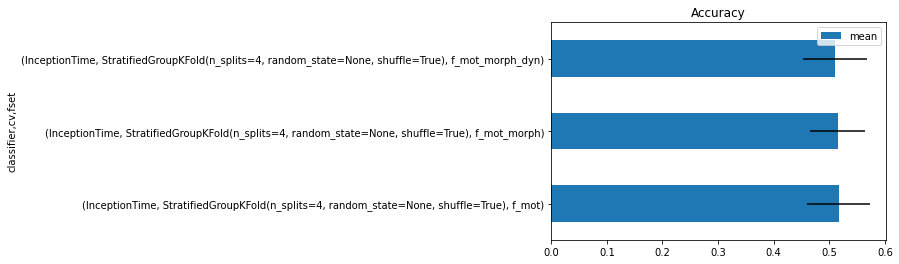

In [75]:


print(scores_inceptiontime.groupby(['fset','epochs']).agg([np.mean]))
print(scores_inceptiontime.groupby(['fset','epochs']).std())#agg([np.std]))
print(scores_inceptiontime.shape)

%matplotlib inline
from scipy.stats import sem
acc = scores_inceptiontime.groupby(['classifier','cv','fset']).agg([np.mean, np.std, sem])['accuracy']
acc.plot(title='Accuracy', kind='barh', y='mean', xerr='std')

In [ ]:
scores

,accuracy,precision,recall,f1,cv,fest,epochs
0,0.465753,0.405405,0.468750,0.434783,GroupKFold(n_splits=4),f_mot,3
1,0.513889,0.523077,0.894737,0.660194,GroupKFold(n_splits=4),f_mot,3
2,0.388889,0.000000,0.000000,0.000000,GroupKFold(n_splits=4),f_mot,3
3,0.416667,0.000000,0.000000,0.000000,GroupKFold(n_splits=4),f_mot,3


In [ ]:
scores.groupby(['cv','fest','epochs']).agg([np.mean, np.std])

accuracy            ...        f1          
                                         mean       std  ...      mean       std
cv                     fest  epochs                      ...                    
GroupKFold(n_splits=4) f_mot 3       0.446299  0.055139  ...  0.273744  0.329216

[1 rows x 8 columns]

In [ ]:
acc
np.std(acc, ddof=1)

0.05513880591882795

In [ ]:
#pd.DataFrame([3,4,5,6], columns=scoring)
df = pd.DataFrame(columns=scoring)
df.loc[len(df)] = [3,4,5,6]
df

,accuracy,precision,recall,f1
0,3,4,5,6


In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
classifier = KNeighborsTimeSeriesClassifier(n_neighbors=5)

scores_all = []
for fset in fsets.keys():
    #print()
    #print("####")
    #print("Feature set:" + fset)
    #print("####")
    X, dfX, y, groups, debug_polar, debug_data = prepare_Xy(data, fset)

    scores = cv_sgkf(classifier, X, y, groups, repeats=20)
    scores['classifier'] = 'KNeighborsTSC'
    scores['fset'] = fset
    scores_all.append(scores)
    #break
    #scores2 = cv_gss(classifier, X, y, groups)
    #scores3 = cv_logo(classifier, X, y, groups)


scores_kneighbors = pd.concat(scores_all)
print(scores_kneighbors.groupby(['cv','fset']).mean())
print(scores_kneighbors.groupby(['cv','fset']).std())
print(scores_kneighbors.shape)

                                      accuracy  precision    recall        f1
cv                   fset                                                    
StratifiedGroupKFold f_mot            0.509991   0.543703  0.515774  0.524053
                     f_mot_morph      0.560028   0.583917  0.630133  0.597484
                     f_mot_morph_dyn  0.489837   0.526622  0.489904  0.500172
                                      accuracy  precision    recall        f1
cv                   fset                                                    
StratifiedGroupKFold f_mot            0.053622   0.083697  0.072364  0.057065
                     f_mot_morph      0.056571   0.094279  0.102543  0.066039
                     f_mot_morph_dyn  0.047196   0.084276  0.080179  0.053144
(240, 7)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


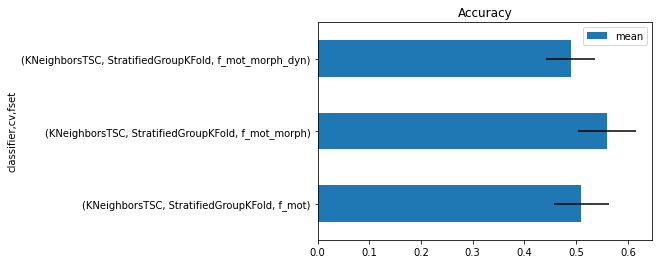

In [ ]:
%matplotlib inline
from scipy.stats import sem
acc = scores_kneighbors.groupby(['classifier','cv','fset']).agg([np.mean, np.std, sem])['accuracy']
acc.plot(title='Accuracy', kind='barh', y='mean', xerr='std')

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
#classifier = RidgeClassifier()
#classifier.fit(X_transform, y)


scores_all = []
for fset in fsets.keys():
    #print(fset)
    X, dfX, y, groups, debugm, debugn = prepare_Xy(data, fset)

    rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
    rocket.fit(dfX)
    X_transform = rocket.transform(dfX)

    #classifier.fit(X_transform, y)
    #scores = classifier.score(X_transform, y)
    #print_score_mean_and_std(scores)
    scores = cv_sgkf(classifier, X_transform, y, groups, repeats=20)
    scores['classifier'] = 'Rocket'
    scores['fset'] = fset
    scores_all.append(scores)

    #scores1 = cv_gkf(classifier, X_transform, y, groups, 4)
    #scores1 = cv_gss(classifier, X_transform, y, groups)
    #scores1 = cv_logo(classifier, X_transform, y, groups)
    
scores_rocket = pd.concat(scores_all)
print(scores_rocket.groupby(['cv','fset']).mean())
print(scores_rocket.groupby(['cv','fset']).std())
print(scores_rocket.shape)


                                      accuracy  precision    recall        f1
cv                   fset                                                    
StratifiedGroupKFold f_mot            0.506968   0.532053  0.701648  0.594547
                     f_mot_morph      0.501299   0.529454  0.580694  0.547612
                     f_mot_morph_dyn  0.458474   0.496534  0.551519  0.514540
                                      accuracy  precision    recall        f1
cv                   fset                                                    
StratifiedGroupKFold f_mot            0.051802   0.065517  0.142934  0.058775
                     f_mot_morph      0.054693   0.075789  0.096282  0.061458
                     f_mot_morph_dyn  0.057252   0.089588  0.092688  0.063324
(240, 7)


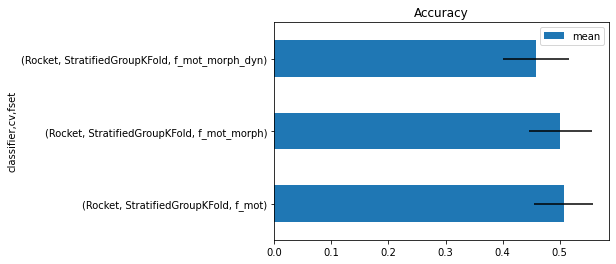

In [ ]:
%matplotlib inline
from scipy.stats import sem
acc = scores_rocket.groupby(['classifier','cv','fset']).agg([np.mean, np.std, sem])['accuracy']
acc.plot(title='Accuracy', kind='barh', y='mean', xerr='std')



1.   Stratified split (add function, with loop)
2.   Infinity loop to check epoch effect for inceptiontime
3.   SHAP for NN, TSC
4.   plot acc (mean, std)



In [ ]:
# https://www.sktime.org/en/stable/examples/rocket.html

sklearn.__version__
from sktime.datasets import load_basic_motions  # multivariate dataset
X_train, y_train = load_basic_motions(split="train", return_X_y=True)
print(X_train.shape)
print(y_train.shape)

#X_train.info()
#y_train
#X
#X_train.head()

rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)
classifier.score(X_train_transform, y_train)

#X_test, y_test = load_basic_motions(split="test", return_X_y=True)
#X_test_transform = rocket.transform(X_test)

#classifier.score(X_test_transform, y_test)



(40, 6)
(40,)


1.0

In [ ]:
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier

##
## This is too slow, skip...
##

# https://stackoverflow.com/questions/57015499/how-to-use-dynamic-time-warping-with-knn-in-python
#custom metric
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
#parameters = {'n_neighbors':[2, 4, 8]}
classifier = KNeighborsClassifier(metric=DTW, n_neighbors=5)
#classifier = KNeighborsClassifier(n_neighbors=3)

for fset in fsets.keys():
    print(fset)
    X, dfX, y, groups, debug_polar, debug_data = prepare_Xy(data, fset)

    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    nsamples, nx, ny = X.shape
    Xrs = X.reshape((nsamples,nx*ny))

    #scores1 = cv_gkf(classifier, X, y, groups, 4)
    scores1 = cv_gkf(classifier, Xrs, y, groups, 4)
    #scores2 = cv_gss(classifier, Xrs, y, groups)
    #scores3 = cv_logo(classifier, Xrs, y, groups)

    break

# These don't work with multi-variate time series

from sktime.classification.distance_based import ElasticEnsemble
classifier = ElasticEnsemble()
scores = cv_gkf(classifier, X, y, groups, 30)

from sktime.classification.hybrid import HIVECOTEV1
classifier = HIVECOTEV1()
scores = cv_gkf(classifier, X, y, groups, 30)

from sktime.classification.interval_based import SupervisedTimeSeriesForest
classifier = SupervisedTimeSeriesForest()
scores = cv_gkf(classifier, X, y, groups, 30)

from sktime.classification.interval_based import TimeSeriesForestClassifier
classifier = TimeSeriesForestClassifier()
scores = cv_gkf(classifier, X, y, groups, 30)

from dtaidistance import dtw

# https://stackoverflow.com/questions/57015499/how-to-use-dynamic-time-warping-with-knn-in-python

classifier = KNeighborsClassifier(metric=dtw.distance, n_neighbors=3)
scores1 = cv_gkf(classifier, d2_train_dataset, y, groups, 5)


KeyboardInterrupt: ignored

In [ ]:
classifier.predict(test_X, test_y, None, None, None, return_df_metrics=True)

,precision,accuracy,recall,duration
0,1.0,1.0,1.0,0.0


In [ ]:
classifier.predict(X, y, None, None, None, return_df_metrics=True)

,precision,accuracy,recall,duration
0,1.0,1.0,1.0,0.0


In [ ]:
data.plot(x='x', y='y', kind='scatter')
test_data.plot(x='x', y='y', kind='scatter')
X[1::]
X
test_X[1::]

array([[[1.48775094e+02, 1.48223297e+02, 1.48432022e+02, ...,
         1.48195861e+02, 1.48427440e+02, 1.50818286e+02],
        [7.02543396e-01, 6.97421184e-01, 7.15006830e-01, ...,
         7.13034947e-01, 7.01174456e-01, 6.97146646e-01],
        [5.18956216e+01, 5.09703746e+01, 5.37366394e+01, ...,
         5.40104346e+01, 5.27483358e+01, 5.12485522e+01]],

       [[3.43425104e+02, 3.42981250e+02, 3.45090994e+02, ...,
         3.40876197e+02, 3.43375655e+02, 3.43823644e+02],
        [5.12528304e-01, 5.13641899e-01, 5.12298510e-01, ...,
         5.28090448e-01, 5.24113067e-01, 5.31084880e-01],
        [1.00480830e+02, 1.00031868e+02, 9.74390834e+01, ...,
         1.00321360e+02, 9.88514145e+01, 9.74476583e+01]],

       [[3.22193282e+02, 3.19348898e+02, 3.19883082e+02, ...,
         3.21775293e+02, 3.20028480e+02, 3.20674109e+02],
        [6.31771323e-01, 6.32913998e-01, 6.33587244e-01, ...,
         6.31692487e-01, 6.32221723e-01, 6.32644071e-01],
        [9.07262263e+01, 9.21184567e

In [ ]:
history = pd.read_csv(output_directory + "history.csv")
history.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.667784,0.594332,0.824302,0.529412,0.001
1,0.625503,0.631076,0.768543,0.540369,0.001
2,0.622573,0.636019,0.706758,0.566897,0.001
3,0.620602,0.638655,0.734906,0.594579,0.001
4,0.600128,0.650849,0.766790,0.581699,0.001


In [ ]:
data.groupby(by=['serum_conc_percent'])['file'].count()

serum_conc_percent
0.3     29237
10.0    21764
Name: file, dtype: int64

In [ ]:
test_X.shape

(289, 3, 30)

<Figure size 576x576 with 0 Axes>

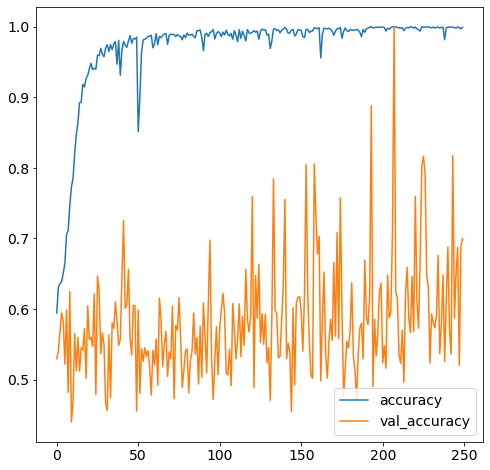

In [ ]:
plt.close("all")
plt.figure()
history.plot(y=["accuracy","val_accuracy"])


In [ ]:
data.columns

Index([                    'file',                 'particle',
             'script_version_git',                     'date',
                          'guide',                     'time',
             'serum_conc_percent',                    'frame',
                              'y',                        'x',
                       'y_micron',            'diff_y_micron',
                       'x_micron',            'diff_x_micron',
                 'diff_xy_micron',        'diff_xy_micron**2',
                    'area_micron',             'perimeter_au',
              'perimeter_au_norm',             'min_dist_pxs',
                'min_dist_micron',            'sqrt(area/pi)',
       'min_dist/(sqrt(area/pi))',                  'comment',
                   'comment_long',               'Unnamed: 0',
                           'mass',                     'size',
                            'rho',                      'phi',
                   ('rho', 'phi')],
      dtype='object